# Superstore Sales Analysis Project

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Setup paths and directories
data_dir = "data"
plots_dir = "plots"

os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

## 1. Load and Prepare Data

In [2]:
cleaned_data_path = os.path.join(data_dir, "Cleaned_Superstore_Sales.csv")
df = pd.read_csv(cleaned_data_path)

# Convert 'Order Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

print("Data loaded. Sample:")
display(df.head())

Data loaded. Sample:


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Revenue,Profit Margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,261.960000,0.160000
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,731.940000,0.300000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,14.620000,0.470000
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,526.667625,-0.727273
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,17.894400,0.140625


## 2. Overall Monthly Sales Trend

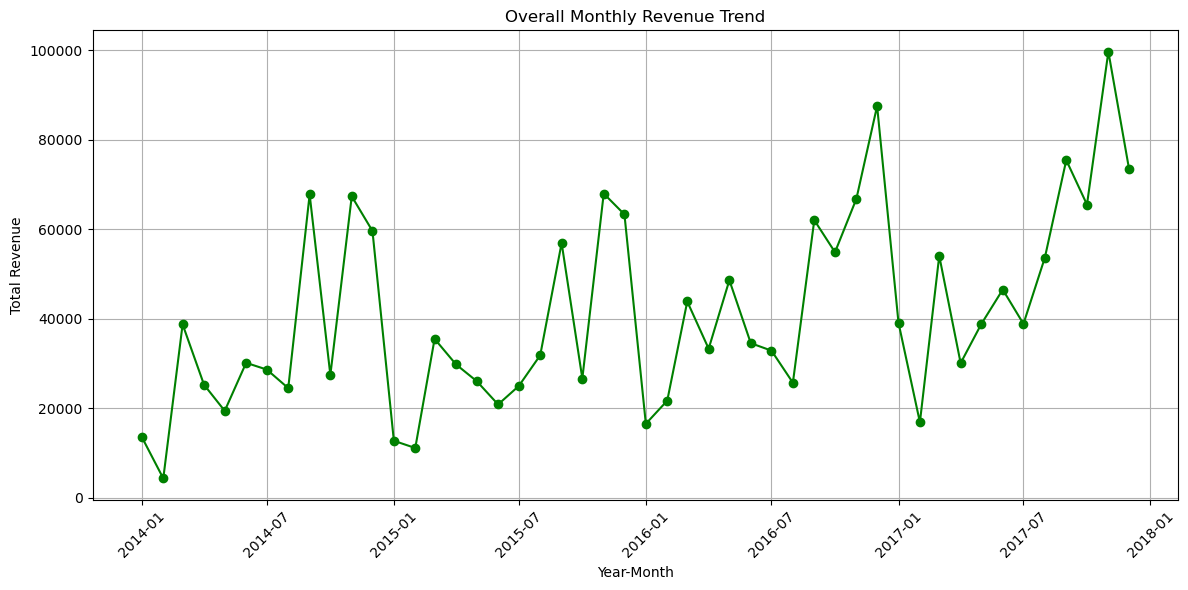

In [3]:
df['YearMonth'] = df['Order Date'].dt.to_period('M')
monthly_sales = df.groupby('YearMonth')['Revenue'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Revenue'], marker='o', color='green')
plt.title('Overall Monthly Revenue Trend')
plt.xlabel('Year-Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'overall_sales_trend.png'))
plt.show()

monthly_sales.to_csv(os.path.join(data_dir, "overall_sales_trends.csv"), index=False)

## 3. Category-wise Sales Trend

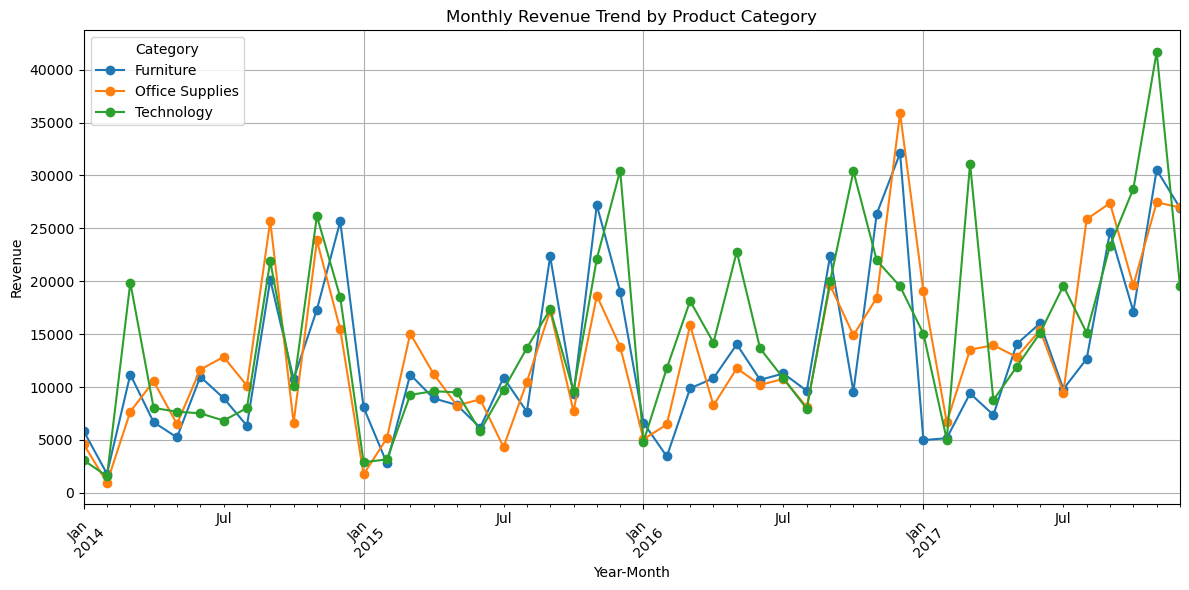

In [4]:
category_sales = df.groupby(['YearMonth', 'Category'])['Revenue'].sum().unstack()

category_sales.plot(figsize=(12,6), marker='o')
plt.title('Monthly Revenue Trend by Product Category')
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'category_sales_trend.png'))
plt.show()

category_sales.reset_index().to_csv(os.path.join(data_dir, "category_sales_trends.csv"), index=False)

## 4. RFM Analysis

RFM scores saved to 'data\rfm_scores.csv'.


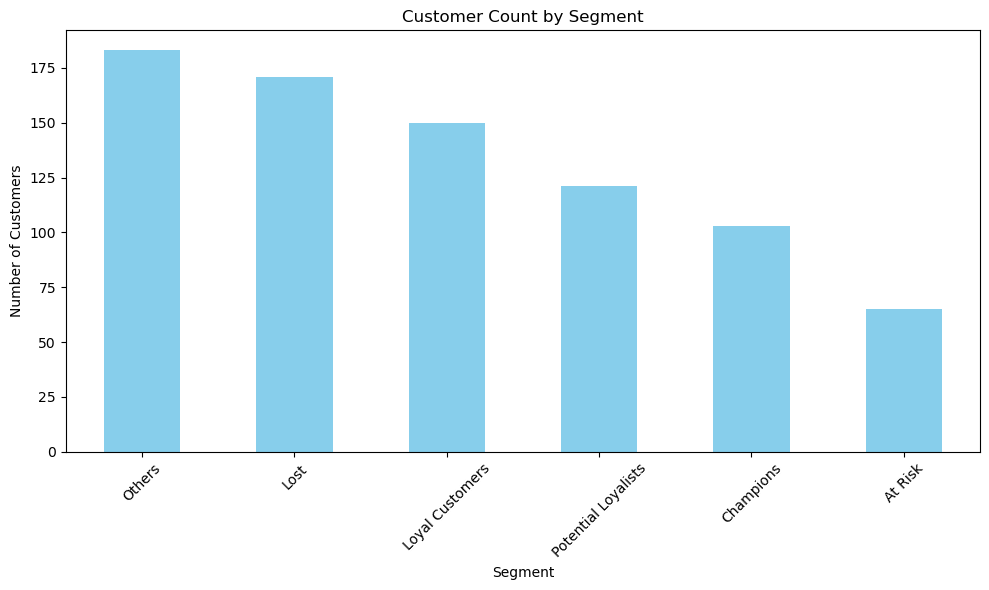

Segment Summary Statistics:


Customer Count     Monetary                Frequency  \
                             count         mean            sum      mean   
Segment                                                                    
At Risk                         65  1911.566358  124251.813268  5.984615   
Champions                      103  4629.149502  476802.398663  9.300971   
Lost                           171  1456.885838  249127.478309  3.713450   
Loyal Customers                150  3498.454047  524768.107044  8.633333   
Others                         183  2270.457573  415493.735801  4.540984   
Potential Loyalists            121  1522.109032  184175.192874  7.446281   

                        Recency  
                           mean  
Segment                          
At Risk              240.184615  
Champions             25.000000  
Lost                 377.549708  
Loyal Customers      146.013333  
Others                45.486339  
Potential Loyalists   34.983471

In [5]:
# Reference date for Recency calculation: max order date + 1 day
reference_date = df['Order Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (reference_date - x.max()).days,  # Recency
    'Order ID': 'nunique',  # Frequency
    'Revenue': 'sum'       # Monetary
}).reset_index()

rfm.rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

# Filter customers with positive Monetary value
rfm = rfm[rfm['Monetary'] > 0]

# Score RFM
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Segment assignment function
def assign_rfm_segment(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['F_Score'] >= 4 and row['R_Score'] < 4:
        return 'Loyal Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] < 4:
        return 'Potential Loyalists'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'At Risk'
    elif row['R_Score'] <= 2 and row['F_Score'] <= 2:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(assign_rfm_segment, axis=1)

# Save RFM results
rfm_output_path = os.path.join(data_dir, "rfm_scores.csv")
rfm.to_csv(rfm_output_path, index=False)
print(f"RFM scores saved to '{rfm_output_path}'.")

# Plot customer count by segment
plt.figure(figsize=(10,6))
rfm['Segment'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Customer Count by Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "customer_segments.png"))
plt.show()

# Segment summary stats
segment_summary = rfm.groupby('Segment').agg({
    'Customer ID': 'count',
    'Monetary': ['mean', 'sum'],
    'Frequency': 'mean',
    'Recency': 'mean'
}).rename(columns={'Customer ID': 'Customer Count'})

print("Segment Summary Statistics:")
display(segment_summary)

## 5. Profitability Analysis

Profitability summary saved to 'data\profitability_summary.csv'.


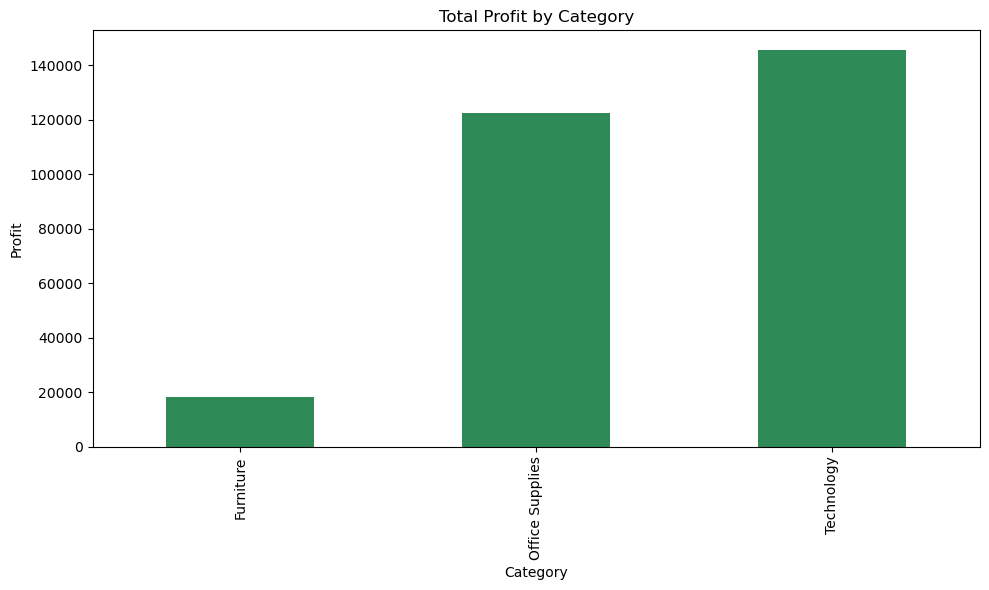

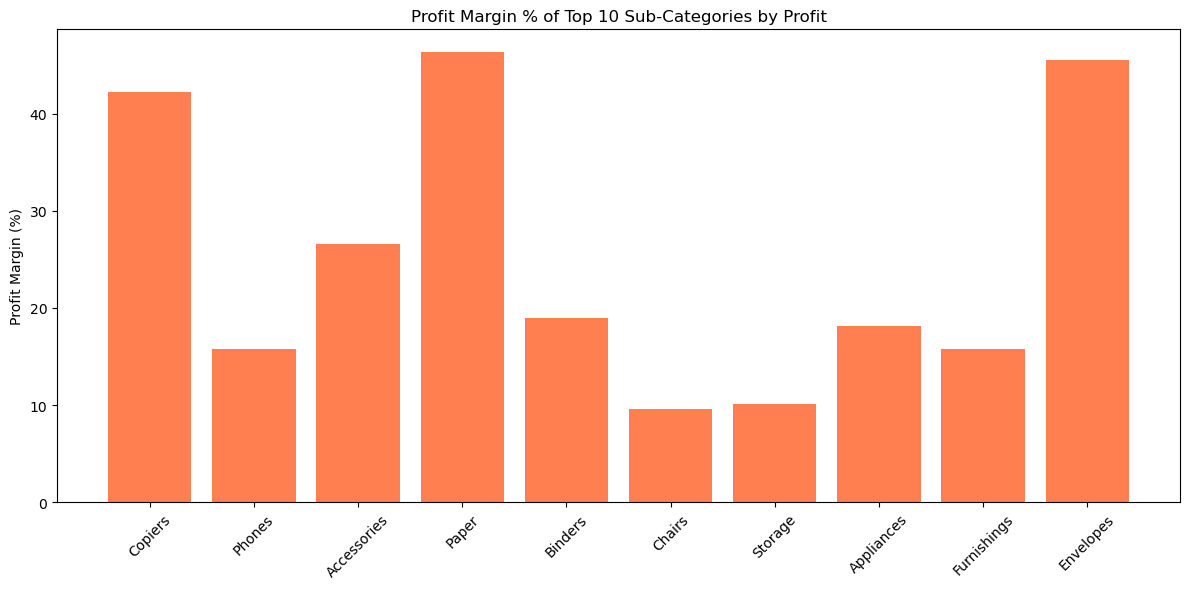

In [6]:
profit_summary = df.groupby(['Category', 'Sub-Category']).agg({
    'Profit': 'sum',
    'Revenue': 'sum'
}).reset_index()

profit_summary['Profit Margin %'] = (profit_summary['Profit'] / profit_summary['Revenue']) * 100

profitability_csv_path = os.path.join(data_dir, "profitability_summary.csv")
profit_summary.to_csv(profitability_csv_path, index=False)
print(f"Profitability summary saved to '{profitability_csv_path}'.")

# Plot total profit by category
plt.figure(figsize=(10,6))
category_profit = profit_summary.groupby('Category')['Profit'].sum()
category_profit.plot(kind='bar', color='seagreen')
plt.title('Total Profit by Category')
plt.ylabel('Profit')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'total_profit_by_category.png'))
plt.show()

# Plot profit margin of top 10 sub-categories by profit
top_subcategories = profit_summary.sort_values(by='Profit', ascending=False).head(10)
plt.figure(figsize=(12,6))
plt.bar(top_subcategories['Sub-Category'], top_subcategories['Profit Margin %'], color='coral')
plt.title('Profit Margin % of Top 10 Sub-Categories by Profit')
plt.ylabel('Profit Margin (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'profit_margin_top_subcategories.png'))
plt.show()